In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys
sys.path.append('..')
import treadmill_dataset
from treadmill_dataset import TreadmillDataset, TreadmillRandomFrameSampler

import pandas as pd
import numpy as np
import torchvision
import imageio
import torch
import os
import re

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from random import shuffle
from rhodin.python.utils import datasets as rhodin_utils_datasets
from rhodin.python.utils import io as rhodin_utils_io
from tqdm import tqdm

import importlib
importlib.reload(treadmill_dataset)

<module 'treadmill_dataset' from '../treadmill_dataset.py'>

In [2]:
config_dict_module = rhodin_utils_io.loadModule("../configs/config_pose_debug.py")
config_dict = config_dict_module.config_dict
print (config_dict['save_every'])
train_subjects = ['ART', 'HOR', 'LAC', 'LAR', 'LAZ', 'LEA', 'LOR', 'PRA']
config_dict['train_subjects'] = train_subjects
config_dict['dataset_folder_train_mocap'] = '/Midgard/home/sbroome/lameness/treadmill_lameness_mocap_ci_may11/mocap/'
config_dict['dataset_folder_train_rgb'] = '/Midgard/home/sbroome/lameness/animals_data/'

100000


### Look at the .mat data

In [13]:
import scipy.io as scio
subjects_list = []

def get_frame_inds_for_clip(clip_id):
    """ args clip_id: str
        Give list of RGB frame indices from the animals_data dir.
        return frame_inds: [int]
    """
    # The RGB frames (.png-files) are in animals_data/[clip_id]/[clip_id]_01/
    path = os.path.join(config_dict['dataset_folder_train_rgb'], clip_id, clip_id+'_01')
    frame_inds = []
    for filename in os.listdir(path):
        if filename.endswith(".png"):
            frame_ind = int(filename[5:9])
            frame_inds.append(frame_ind)
    return frame_inds

for ts in train_subjects:
    print('subject: ', ts)
    subject_list = []
    for filename in os.listdir(config_dict['dataset_folder_train_mocap']):
        if filename.startswith(ts) and filename.endswith(".mat"):
            subject = filename[:3]
            clip_id = filename[:-4]
            mocap = scio.loadmat(os.path.join(config_dict['dataset_folder_train_mocap'], filename))
            path_annotation = os.path.join(config_dict['dataset_folder_train_mocap'][:-6], 'total_infor_each_video')
            print('Path to annotation .mat-file: ', path_annotation)
            annotation = scio.loadmat(os.path.join(path_annotation,'{}_total_infor.mat'.format(clip_id)))
            frame_index_for_mocap = annotation['horse']['start_frame'][0][0]-1
            frame_index_for_mocap = frame_index_for_mocap[0] # Nested list
            first_frame = int(annotation['horse']['start_image'][0][0][0].split('.')[0][5:])
            rgb_frame_inds = get_frame_inds_for_clip(clip_id)
            nb_mocap = len(frame_index_for_mocap)
            nb_rgb = len(rgb_frame_inds)-first_frame
            
            min_nb = min(nb_mocap, nb_rgb)
            print('\n', 'Clip ID: ', clip_id)
            print('Mocap frame index: ', frame_index_for_mocap)
            print('Start frame RGB: ', first_frame)
            print('Number of mocap frames: ', nb_mocap)
            print('Number of RGB frames: ', nb_rgb)
            print('\n')
            for idx, fi in enumerate(frame_index_for_mocap):
                if idx+1 > min_nb:
                    continue
                # fi is mocap ind (between 0~5000, idx is rgb ind (just range(~502))
                rgb_idx = first_frame + idx
                row_list = [clip_id, fi, rgb_idx]
                subject_list.append(row_list)
    subjects_list.append(subject_list)

subject:  ART
Path to annotation .mat-file:  /Midgard/home/sbroome/lameness/treadmill_lameness_mocap_ci_may11/total_infor_each_video

 Clip ID:  ARTqt_iFt1_R120
Mocap frame index:  [   6   16   26   36   46   56   66   77   87   97  108  118  128  138
  149  159  169  179  190  200  211  221  231  241  252  262  272  282
  293  303  313  324  334  344  354  364  374  385  395  405  415  425
  435  445  456  467  477  487  497  508  518  528  538  548  558  568
  578  589  600  610  620  630  640  651  661  671  681  691  702  713
  724  734  744  754  764  774  784  795  806  816  826  836  847  857
  867  877  887  897  908  918  928  938  948  958  968  979  989  999
 1010 1020 1030 1040 1050 1060 1070 1081 1091 1102 1113 1123 1134 1144
 1154 1164 1174 1185 1195 1205 1215 1225 1236 1246 1256 1266 1276 1286
 1296 1306 1317 1327 1338 1348 1359 1369 1379 1389 1399 1409 1419 1430
 1440 1450 1461 1471 1481 1491 1502 1512 1522 1532 1542 1552 1562 1572
 1583 1594 1604 1614 1624 1634 1644 16

### Inspect the mocap data

(51, 3, 5120)


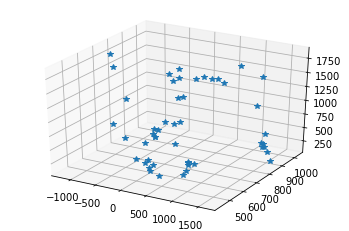

In [6]:
import scipy.io as scio
from mpl_toolkits import mplot3d
counter = 0
for subject in train_subjects:
    for filename in os.listdir(config_dict['dataset_folder_train_mocap']):
        if filename.startswith(subject) and filename.endswith(".mat"):
            while counter < 1:
                mocap = scio.loadmat(os.path.join(config_dict['dataset_folder_train_mocap'], filename))
                clip_id = filename[:-4]
                mocap  = mocap[clip_id]['Trajectories'][0][0][0][0][0][0]['Data'][0]
                mocap = mocap[:,:3,:]
                print(mocap.shape)
                fig = plt.figure()
                ax = plt.axes(projection='3d')
                ax.plot3D(mocap[:,0,0], mocap[:,1,0], mocap[:,2,0], '*')
                row_list = [subject]
                counter += 1

In [14]:
len(subjects_list)

8

In [15]:
for subj in range(len(train_subjects)):
    print(len(subjects_list[subj]))

13438
9458
10948
11450
3484
8457
10948
11941


In [16]:
subjects_list[0][:5]

[['ARTqt_iFt1_R120', 6, 4],
 ['ARTqt_iFt1_R120', 16, 5],
 ['ARTqt_iFt1_R120', 26, 6],
 ['ARTqt_iFt1_R120', 36, 7],
 ['ARTqt_iFt1_R120', 46, 8]]

In [17]:
column_headers = ['clip_id', 'mocap_index', 'rgb_index']

# Save the frame index

In [18]:
for subj_ind, subj in enumerate(train_subjects):
    df = pd.DataFrame(subjects_list[subj_ind], columns=column_headers)
    print(df.head())
    print(len(df))
    df.to_csv('../../metadata/treadmill_frame_index_{}.csv'.format(subj))

           clip_id  mocap_index  rgb_index
0  ARTqt_iFt1_R120            6          4
1  ARTqt_iFt1_R120           16          5
2  ARTqt_iFt1_R120           26          6
3  ARTqt_iFt1_R120           36          7
4  ARTqt_iFt1_R120           46          8
13438
           clip_id  mocap_index  rgb_index
0  HORqt_iFt1_0000            6          4
1  HORqt_iFt1_0000           16          5
2  HORqt_iFt1_0000           26          6
3  HORqt_iFt1_0000           37          7
4  HORqt_iFt1_0000           47          8
9458
           clip_id  mocap_index  rgb_index
0  LACqt_iHt2_L050            4          4
1  LACqt_iHt2_L050           14          5
2  LACqt_iHt2_L050           24          6
3  LACqt_iHt2_L050           34          7
4  LACqt_iHt2_L050           45          8
10948
           clip_id  mocap_index  rgb_index
0  LARqt_iHt1_0000            0          4
1  LARqt_iHt1_0000           10          5
2  LARqt_iHt1_0000           20          6
3  LARqt_iHt1_0000           30      

#### Example subject df

In [19]:
df.head()

,clip_id,mocap_index,rgb_index
0,PRAqt_iHt2_0000,5,4
1,PRAqt_iHt2_0000,15,5
2,PRAqt_iHt2_0000,26,6
3,PRAqt_iHt2_0000,37,7
4,PRAqt_iHt2_0000,47,8


## Get mean pose

In [5]:
import scipy.io as scio
subjects_list = []

def get_frame_inds_for_clip(clip_id):
    """ args clip_id: str
        Give list of RGB frame indices from the animals_data dir.
        return frame_inds: [int]
    """
    # The RGB frames (.png-files) are in animals_data/[clip_id]/[clip_id]_01/
    path = os.path.join(config_dict['dataset_folder_train_rgb'], clip_id, clip_id+'_01')
    frame_inds = []
    for filename in os.listdir(path):
        if filename.endswith(".png"):
            frame_ind = int(filename[5:9])
            frame_inds.append(frame_ind)
    return frame_inds

poses = []

path_annotation = os.path.join(config_dict['dataset_folder_train_mocap'][:-6], 'total_infor_each_video')
print('Path to annotation .mat-file: ', path_annotation)
for ts in train_subjects:
    print('subject: ', ts)
    subject_list = []
    for filename in os.listdir(config_dict['dataset_folder_train_mocap']):
        if filename.startswith(ts) and filename.endswith(".mat"):
            subject = filename[:3]
            clip_id = filename[:-4]
            
            mocap = scio.loadmat(os.path.join(config_dict['dataset_folder_train_mocap'], filename))
            mocap  = mocap[clip_id]['Trajectories'][0][0][0][0][0][0]['Data'][0]
            mocap = mocap[:,:3,:]
            if mocap.shape[0] == 51:
                mocap = mocap[1:,:,:]
            annotation = scio.loadmat(os.path.join(path_annotation,'{}_total_infor.mat'.format(clip_id)))
            frame_index_for_mocap = annotation['horse']['start_frame'][0][0]-1
            frame_index_for_mocap = frame_index_for_mocap[0] # Nested list

            rgb_frame_inds = get_frame_inds_for_clip(clip_id)
            nb_mocap = len(frame_index_for_mocap)
            for i in range(10):
                random_frame_ind = np.random.randint(nb_mocap)
                random_pose = mocap[:,:,random_frame_ind]
                poses.append(random_pose)
print(len(poses))
pose_mean = np.nanmean(poses, axis=0)
pose_std = np.nanstd(poses, axis=0)
print(pose_mean)
print(pose_std)

Path to annotation .mat-file:  /Midgard/home/sbroome/lameness/treadmill_lameness_mocap_ci_may11/total_infor_each_video
subject:  ART
subject:  HOR
subject:  LAC
subject:  LAR
subject:  LAZ
subject:  LEA
subject:  LOR
subject:  PRA
1610
[[-1278.5274188    845.20157467  1407.1690306 ]
 [-1108.85513691   771.69470884  1787.17833054]
 [  -99.70395326   783.42728025  1582.00281655]
 [   72.3511012    780.63776993  1548.241071  ]
 [  303.77684242   784.50038885  1524.43445074]
 [  438.33759675   787.19810101  1562.16789516]
 [  582.71105995   786.45880454  1559.45895641]
 [  723.61218171   790.02924629  1595.41825104]
 [  866.50427075   790.96224163  1553.41381378]
 [ -375.50883263   962.38518438  1380.88184753]
 [ -523.28250784  1000.0359175   1055.35924693]
 [ -303.14666613  1008.23326679   815.68924296]
 [ -394.84123124   953.21705482   434.45900947]
 [ -404.11866897   906.61223098   326.2707578 ]
 [ -341.87332228   910.97052014   342.52831929]
 [ -365.87906761   908.08681139   235.234221

(50, 3)


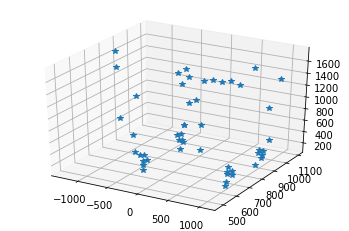

In [9]:
import scipy.io as scio
from mpl_toolkits import mplot3d
counter = 0
print(pose_mean.shape)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(pose_mean[:,0], pose_mean[:,1], pose_mean[:,2], '*')
row_list = [subject]

In [6]:
np.save('../../data/treadmill_pose_mean.npy', pose_mean)
np.save('../../data/treadmill_pose_std.npy', pose_std)

## Get median background

In [25]:
from helpers import util
from matplotlib.pyplot import imread, imsave

frame_folder = config_dict['dataset_folder_train_rgb']
out_folder = '../../data/median_bg_treadmill/'
skip_num = 10
util.mkdir(out_folder)


def get_all_jpg_paths(frame_folder):
    paths = []
    for root, dirs, files in os.walk(frame_folder):
        for name in files:
            if name.endswith((".png")):
                path = os.path.join(root, name)
                paths.append(path)
    return paths

def get_frame_paths():
    """ args clip_id: str
        Give list of RGB frame indices from the animals_data dir.
        return frame_inds: [int]
    """
    # The RGB frames (.png-files) are in animals_data/[clip_id]/[clip_id]_01/
    for ts in train_subjects:
        print('subject: ', ts)
        frame_paths = []
        for filename in os.listdir(config_dict['dataset_folder_train_mocap']):
            if filename.startswith(ts) and filename.endswith(".mat"):
                subject = filename[:3]
                clip_id = filename[:-4]
                path = os.path.join(config_dict['dataset_folder_train_rgb'], clip_id, clip_id+'_01')
                for filename in os.listdir(path):
                    if filename.endswith(".png"):
                        frame_path = os.path.join(path, filename)
                        frame_paths.append(frame_path)
    return frame_paths
    

# path_list = get_all_jpg_paths(frame_folder)
path_list = get_frame_paths()
path_list = path_list[::skip_num]
nb_frames = len(path_list)
frame_list = []

# Read and sort images into the right camera list
with tqdm(total=len(path_list)) as pbar:
    for idx, path in enumerate(path_list):
        pbar.update(1)
        img = imread(path)
        frame_list.append(img)
        
ar = np.asarray(frame_list)

med = np.nanmedian(ar, axis=0)
imsave(os.path.join(out_folder,'median_frame.jpg'), med.astype('uint8'))

subject:  ART
subject:  HOR
subject:  LAC
subject:  LAR
subject:  LAZ
subject:  LEA


  0%|          | 0/1205 [00:00<?, ?it/s]

subject:  LOR
subject:  PRA


100%|██████████| 1205/1205 [00:46<00:00, 26.02it/s]


In [18]:
def denormalize(np_array):
    #std then mean, from config file
    return np_array * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

# extract image
def tensor_to_img(output_img):
    output_img = denormalize(output_img)
    output_img = np.clip(output_img, 0, 1)
    return output_img

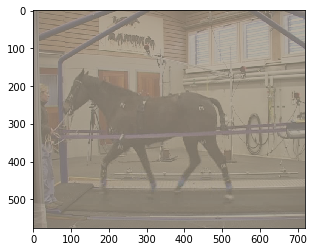

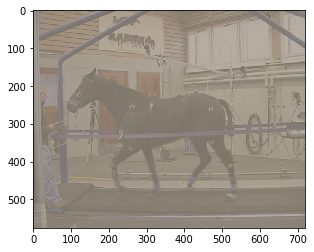

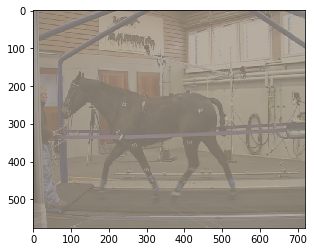

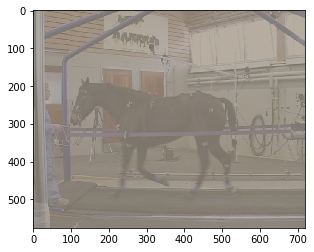

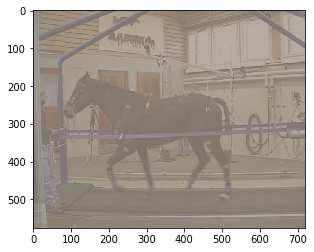

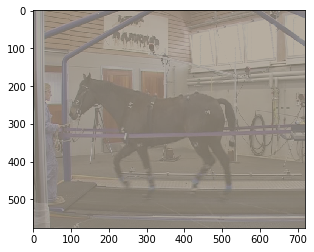

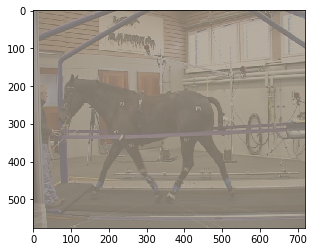

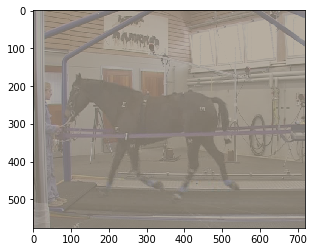

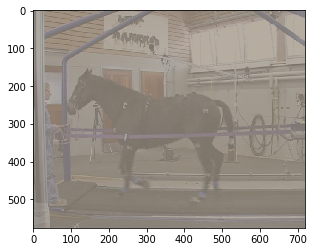

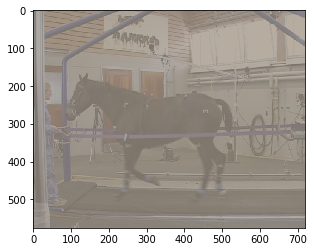

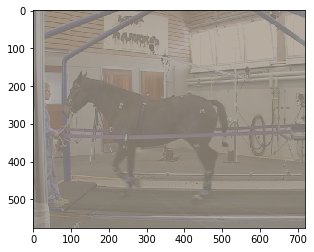

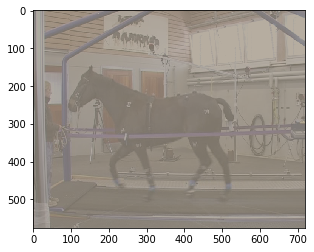

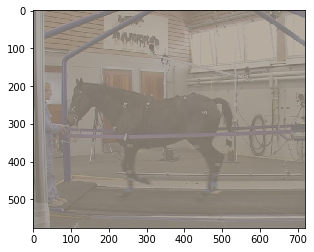

In [19]:
for img in ar:
    plt.imshow(tensor_to_img(img))
    plt.show()

In [26]:
med.shape

(576, 720, 3)

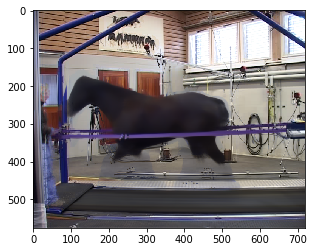

In [27]:
plt.imshow(med)